In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error
import torch
import torch.nn as nn
import os
import joblib

from src.nn_modeling import *

In [2]:
#config
DATA_PATH = "data/"
OUTPUT_PATH = "output/"
N_SAMPLE = 16000 #number of samples 
VAL_FRAC = 0.2

EXPERIMENTS_DICT = {
    'exp_A' : {
        'model_class' : SimpleNNRegressor,
        'model_kwargs' : {
            "input_dim": 9,
            "hidden_sizes": [64, 64, 32, 32, 16, 8],
        },
        'learning_rate' : 0.01,
        'epochs' : 5,
        'batch_size' : 32,
        'device' : 'cpu'
    },
    # 'exp_B' : {
    #     'model_class' : SimpleNNRegressor,
    #     'model_kwargs' : {
    #         "input_dim": 9,
    #         "hidden_sizes": [64, 64, 32, 32, 16, 8],
    #     },
    #     'learning_rate' : 0.001,
    #     'epochs' : 10,
    #     'batch_size' : 32,
    #     'device' : 'cpu'
    # },
    # 'exp_C' : {
    #     'model_class' : SimpleNNRegressor,
    #     'model_kwargs' : {
    #         "input_dim": 9,
    #         "hidden_sizes": [128, 64, 64, 32, 32, 16, 8],
    #     },
    #     'learning_rate' : 0.001,
    #     'epochs' : 10,
    #     'batch_size' : 32,
    #     'device' : 'cpu'
    # },
    # 'exp_D' : {
    #     'model_class' : SimpleNNRegressor,
    #     'model_kwargs' : {
    #         "input_dim": 9,
    #         "hidden_sizes": [128, 128, 64, 64, 32, 32, 16, 16, 8, 8],
    #     },
    #     'learning_rate' : 0.001,
    #     'epochs' : 10,
    #     'batch_size' : 32,
    #     'device' : 'cpu'
    # },
}

In [3]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
print(df_train.shape)
df_train.head(3)

(524164, 11)


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989


In [4]:
df_test = pd.read_csv(DATA_PATH + "test.csv")
print(df_test.shape)
df_test.head(3)

(174722, 10)


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067


In [5]:
feature_cols = [c for c in df_train.columns if c not in ('id', 'BeatsPerMinute')]
feature_cols

['RhythmScore',
 'AudioLoudness',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']

In [6]:
label_col = 'BeatsPerMinute'

### Experiments

In [7]:
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [8]:
df_sample = df_train.sample(n=N_SAMPLE)

df_sample_train, df_sample_val = train_test_split(df_sample, test_size=VAL_FRAC, random_state=1)
X_train = torch.Tensor(df_sample_train[feature_cols].values)
y_train = torch.Tensor(df_sample_train[label_col].values)
X_val = torch.Tensor(df_sample_val[feature_cols].values)
y_val = torch.Tensor(df_sample_val[label_col].values)

print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"X_val shape : {X_val.shape}")
print(f"y_val shape : {y_val.shape}")

X_train shape : torch.Size([12800, 9])
y_train shape : torch.Size([12800])
X_val shape : torch.Size([3200, 9])
y_val shape : torch.Size([3200])


Experiment ID: exp_A
TorchRegressorWrapper(device='cpu', epochs=5, lr=0.01,
                      model_class=<class 'src.nn_modeling.SimpleNNRegressor'>,
                      model_kwargs={'hidden_sizes': [64, 64, 32, 32, 16, 8],
                                    'input_dim': 9})
Model trainable parameter count : 8627


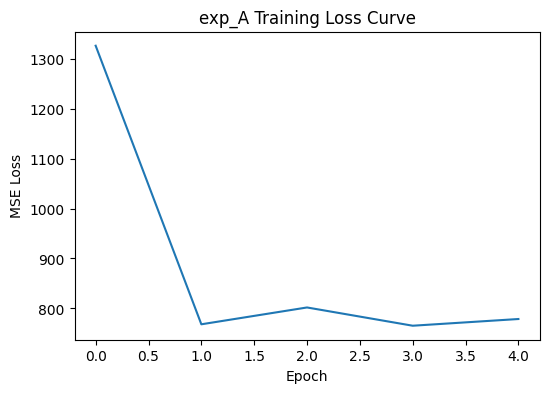

Train RMSE : 26.9541015625
Validation RMSE : 26.75006675720215


In [10]:
for exp in EXPERIMENTS_DICT.keys():
    print("="*100)
    print(f"Experiment ID: {exp}")
    print("="*100)

    #wrap the PyTorch model
    wrapped_model = TorchRegressorWrapper(
        model_class=EXPERIMENTS_DICT[exp]['model_class'],
        model_kwargs=EXPERIMENTS_DICT[exp]['model_kwargs'],
        lr=EXPERIMENTS_DICT[exp]['learning_rate'],
        epochs=EXPERIMENTS_DICT[exp]['epochs'],
        batch_size=EXPERIMENTS_DICT[exp]['batch_size'],
        device=EXPERIMENTS_DICT[exp]['device'],
    )
    print(wrapped_model)
    print(f"Model trainable parameter count : {sum(p.numel() for p in wrapped_model.get_parameters() if p.requires_grad)}")

    # Train sklearn-style
    wrapped_model.fit(X_train, y_train)

    # Save
    save_path = OUTPUT_PATH + f"03_nn_modeling__{exp}.joblib"
    joblib.dump(wrapped_model, save_path)

    # # Load back
    # loaded_model = joblib.load(save_path)

    #Training loss history
    plt.figure(figsize=(6, 4))
    plt.plot(wrapped_model.train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    # plt.legend()
    plt.title(f"{exp} Training Loss Curve")
    plt.show()

    #evaluate performance on validation set
    y_train_preds = wrapped_model.predict(X_train)
    print(f"Train RMSE : {root_mean_squared_error(y_train, y_train_preds)}")
    y_val_preds = wrapped_model.predict(X_val)
    print(f"Validation RMSE : {root_mean_squared_error(y_val, y_val_preds)}")